# Introduction

In this project I will demonstrate how to build a model predicting readmission for patients with diabetes in Python using the following steps
- data exploration
- feature engineering
- building training/validation/test samples
- model selection
- model evaluation

# Project Objective

Predict if a patient with diabetes will be readmitted to the hospital within 30 days. 

# Data set exploration

The data that is used in this project originally comes from the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). The data consists of over 100000 hospital admissions from patients with diabetes from 130 US hospitals between 1999-2008. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [94]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the csv file
df = pd.read_csv('diabetic_data.csv')

In [3]:
print('Number of samples:',len(df))

Number of samples: 101766


Quick overview of the data (columns, variable type and non-null values)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

From briefly, looking through the data columns, we can see there are some identification columns, some numerical columns, some categorical (free-text) columns. These columns will be described in more detail below. 

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


There is some missing data that are represented with ?. We will deal with this in the feature engineering section. 

The most important column here is `readmitted`, which tells us if a patient was hospitalized within 30 days, greater than 30 days or not readmitted. 

In [6]:
# count the number of rows for each type
df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

Text(0, 0.5, 'Count')

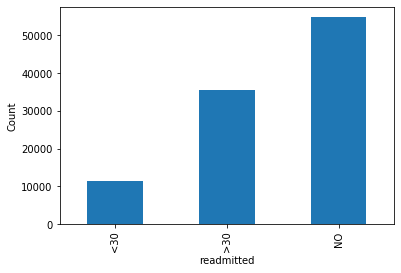

In [7]:
df.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

Another column that is important is `discharge_disposition_id`, which tells us where the patient went after the hospitalization.

In [8]:
df.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

 If we look at the IDs_mapping.csv we can see that 11,13,14,19,20,21 are related to death or hospice. We should remove these samples from the predictive model. 

In [9]:
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

Now let's define an output variable for our binary classification. Here we will try to predict if a patient is likely to be re-admitted within 30 days of discharge.

In [10]:
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')

Let's define a function to calculate the prevalence of population that is readmitted with 30 days. 

In [11]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [12]:
print('Prevalence:%.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

Prevalence:0.114


Around 11% of the population is rehospitalized. This represented an imbalanced classification problem so we will address that below. 

Now we would like to get a feeling of the data for each column in our dataset. Pandas doesn't allow you to see all the columns at once, so let's look at them in groups of 10. 

In [13]:
print('Number of columns:',len(df.columns))

Number of columns: 51


In [14]:
df[list(df.columns)[:10]].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1


In [15]:
df[list(df.columns)[10:20]].head()

,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2
0,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?
1,?,?,59,0,18,0,0,0,276,250.01
2,?,?,11,5,13,2,0,1,648,250
3,?,?,44,1,16,0,0,0,8,250.43
4,?,?,51,0,8,0,0,0,197,157


In [16]:
df[list(df.columns)[20:30]].head()

,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide
0,?,1,None,None,No,No,No,No,No,No
1,255,9,None,None,No,No,No,No,No,No
2,V27,6,None,None,No,No,No,No,No,No
3,403,7,None,None,No,No,No,No,No,No
4,250,5,None,None,No,No,No,No,No,No


In [17]:
df[list(df.columns)[30:40]].head()

,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide
0,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No
2,Steady,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No
4,Steady,No,No,No,No,No,No,No,No,No


In [18]:
df[list(df.columns)[40:]].head()

,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,OUTPUT_LABEL
0,No,No,No,No,No,No,No,No,No,NO,0
1,No,Up,No,No,No,No,No,Ch,Yes,>30,0
2,No,No,No,No,No,No,No,No,Yes,NO,0
3,No,Up,No,No,No,No,No,Ch,Yes,NO,0
4,No,Steady,No,No,No,No,No,Ch,Yes,NO,0


From this, we see that there are a lot of categorical (non-numeric) variables. Note that the variables with _id are also categorical and you can see what the ids refer to with the IDs_mapping.csv. Let's take a look at the unique values for each column. 

In [19]:
# for each column
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 99343 unique values
patient_nbr: 69990 unique values
race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6 

From analysis of the columns, we can see there are a mix of categorical (non-numeric) and numerical data. A few things to point out, 

    - encounter_id and patient_nbr: these are just identifiers and not useful variables
    - age and weight: are categorical in this data set
    - admission_type_id,discharge_disposition_id,admission_source_id: are numerical here, but are IDs (see IDs_mapping). They should be considered categorical. 
    - examide and citoglipton only have 1 value, so we will not use these variables
    - diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information. 
    - medical_speciality - has many categorical variables, so we should consider this when making features. 

# Feature Engineering

In this section, we will create features for our predictive model. For each section, we will add new variables to the dataframe and then keep track of which columns of the dataframe we want to use as part of the predictive model features. We will break down this section into numerical features, categorical features and extra features. 

In this data set, the missing numbers were filled with a question mark. Let's replace it with a nan representation. 

In [20]:
# replace ? with nan
df = df.replace('?',np.nan)

## Numerical Features

The easiest type of features to use is numerical features. These features do not need any modification. The columns that are numerical that we will use are shown below

In [21]:
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

Let's check if there are any missing values in the numerical data. 

In [22]:
df[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

## Categorical Features

The next type of features we want to create are categorical variables. Categorical variables are non-numeric data such as race and gender. To turn these non-numerical data into variables, the simplest thing is to use a technique called one-hot encoding, which will be explained below. 

The first set of categorical data we will deal with are these columns:

In [23]:
cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

Let's check if there are any missing data

In [24]:
df[cols_cat].isnull().sum()

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

`race`, `payer_code`, and `medical_specialty` have missing data. Since these are categorical data, the best thing to do is to just add another categorical type for unknown using the `fillna` function. 

In [25]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

Let's investigate medical specialty before we begin. 

In [26]:
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Psychiatry-Addictive                    1
Dermatology                             1
Speech                                  1
SportsMedicine                          1
Surgery-PlasticwithinHeadandNeck        1
Length: 73, dtype: int64

We can see that most of them are unknown and that the count drops off pretty quickly. We don't want to add 73 new variables since some of them only have a few samples. As an alternative, we can create a new variable that only has 11 options (the top 10 specialities and then an other category). Obviously, there are other options for bucketing, but this is one of the easiest methods. 

In [27]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

In [28]:
df.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64

To convert our categorical features to numbers, we will use a technique called one-hot encoding. In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_Caucasian','race_AfricanAmerican', etc). If the patient's race is Caucasian, the patient gets a 1 under 'race_Caucasian' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the `get_dummies` function. 

Now the problem is that if we create a column for each unique value, we have correlated columns. In other words, the value in one column can be figured out by looking at the rest of the columns. For example, if the sample is not AfricanAmerican, Asian, Causasian, Hispance or Other, it must be UNK. To deal with this, we can use the `drop_first` option, which will drop the first categorical value for each column. 

The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly. 

In [29]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

df[cols_cat_num] = df[cols_cat_num].astype('str')

Now we are ready to make all of our categorical features

In [30]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [31]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


To add the one-hot encoding columns to the dataframe we can use `concat` function. Make sure to use axis = 1 to indicate add the columns. 

In [32]:
df = pd.concat([df,df_cat], axis = 1)

Save the column names of the categorical data. 

In [33]:
cols_all_cat = list(df_cat.columns)

## Extra features

The last two columns we want to make features are `age` and `weight`. Typically, you would think of these as numerical data, but they are categorical in this dataset as shown below.  

In [34]:
df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


One option could be to create categorical data as shown above. Since there is a natural order to these values, it might make more sense to convert these to numerical data. Another example when you would want to do this might be size of a t-shirt (small, medium, large). Let's start with age. 

In [35]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

Let's map these to 0-9 for the numerical data. 

In [36]:
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age_group'] = df.age.replace(age_id)

Now let's look at weight. Recall that this feature is not filled out very often.  

In [37]:
df.weight.notnull().sum()

3125

Instead of creating an ordinal feature that we did above, let's just create a variable to say if weight was filled out or not. The presence of a variable might be predictive regardless of the value. 

In [38]:
df['has_weight'] = df.weight.notnull().astype('int')

Let's keep track of these extra columns too. 

In [39]:
cols_extra = ['age_group','has_weight']

## Engineering Features Summary

In [40]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 143
Numerical Features: 8
Categorical Features: 133
Extra features: 2


Let's check if we are missing any data. 

In [41]:
df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

has_weight              0
pioglitazone_No         0
acarbose_No             0
rosiglitazone_Up        0
rosiglitazone_Steady    0
rosiglitazone_No        0
pioglitazone_Up         0
pioglitazone_Steady     0
tolbutamide_Steady      0
acarbose_Up             0
dtype: int64

let's make a new dataframe that only has the columns of interest

In [42]:
col2use = cols_num + cols_all_cat + cols_extra
df_data = df[col2use + ['OUTPUT_LABEL']]

# Building Training/Validation/Test Samples

So far we have explored our data and created features from the categorical data. It is now time for us to split our data. The idea behind splitting the data is so that you can measure how well your model would do on unseen data. We split into three parts:
    - Training samples: these samples are used to train the model
    - Validation samples: these samples are held out from the training data and are used to make decisions on how to improve the model
    - Test samples: these samples are held out from all decisions and are used to measure the generalized performance of the model
  
In this project, we will split into 70% train, 15% validation, 15% test. 

The first thing I like to do is to shuffle the samples using `sample` in case there was some order (e.g. all positive samples on top). Here `n` is the number. `random_state` is just specified so the entire class gets the same shuffling. You wouldn't need `random_state` in your own projects. 

In [43]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

We can use `sample` again to extract 30% (using `frac`) of the data to be used for validation / test splits. It is important that validation and test come from similar distributions and this technique is one way to do it. 

In [44]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


And now split into test and validation using 50% fraction. 

In [45]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

Note that `.drop` just drops the rows from `df_test` to get the rows that were not part of the sample. We can use this same idea to get the training data. 

In [69]:
# use the rest of the data as training data
df_train =df_data.drop(df_valid_test.index)
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)


At this point, let's check what percent of our groups are hospitalized within 30 days. This is known as prevalence. Ideally, all three groups would have similar prevalance. 

In [70]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 14902):0.117
Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113


The prevalence is about the same for each group. 

Let's verify that we used all the data.

In [71]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 99343)


At this point, you might say, drop the training data into a predictive model and see the outcome. However, if we do this, it is possible that we will get back a model that is 89% accurate. Great! Good job! But wait, we never catch any of the readmissions (recall= 0%). How can this happen? 

What is happening is that we have an imbalanced dataset where there are much more negatives than positives, so the model might just assigns all samples as negative. 

Typically, it is better to balance the data in some way to give the positives more weight. There are 3 strategies that are typically utilized:
    - sub-sample the more dominant class: use a random subset of the negatives
    - over-sample the imbalanced class: use the same positive samples multiple times
    - create synthetic positive data
    
Usually, you will want to use the latter two methods if you only have a handful of positive cases. Since we have a few thousand positive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that has 50% positive and 50% negative. You can also play with this ratio to see if you can get an improvement. 

Since we have done a lot of work, let's save our data.

In [72]:
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

Most machine learning packages like to use an input matrix X and output vector y, so let's create those:

In [73]:
X_train = df_train[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training shapes: (69540, 143) (69540,)
Validation shapes: (14901, 143) (14901,)


Some machine learning models have trouble when the variables are of different size (0-100, vs 0-1000000). To deal with that we can scale the data. Here we will use scikit learn's Standard Scaler  which removes the mean and scales to unit variance. Here I will create a scaler using all the training data, but you could use the balanced one if you wanted. 

In [74]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

We will need this scaler for the test data, so let's save it using a package called `pickle`. 

In [75]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [76]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

Now we can transform our data matrices 

In [77]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

# Model Selection

Wow! so much work to get ready for a model. This is always true in data science. You spend 80-90% cleaning and preparing data. 

In this section, we train a few machine learning models and use a few techniques for optimizing them. We will then select the best model based on performance on the validation set.

We will utilize the following functions to evaluate the performance of the model.

In [78]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive. 

In [79]:
thresh = 0.5

## Model Selection: baseline models

In this section, we will compare the performance of 7 machine learning models using default hyperparameters. 

### Logistic regression

In [95]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [81]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.667
accuracy:0.886
recall:0.016
precision:0.444
specificity:0.997
prevalence:0.113
 
Validation:
AUC:0.664
accuracy:0.887
recall:0.015
precision:0.473
specificity:0.998
prevalence:0.113
 


### Stochastic Gradient Descent

When you have a lot of data logistic regression may take a long time to compute. There is an alternative approach called stochastic gradient descent that works similarly to logistic regression but doesn't use all the data at each iteration. 

In [82]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [83]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.665
accuracy:0.887
recall:0.003
precision:0.568
specificity:1.000
prevalence:0.113
 
Validation:
AUC:0.666
accuracy:0.887
recall:0.001
precision:0.200
specificity:1.000
prevalence:0.113
 


### Decision Tree Classifier

In [84]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [85]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.687
accuracy:0.894
recall:0.077
precision:0.892
specificity:0.998
prevalence:0.113
 
Validation:
AUC:0.640
accuracy:0.882
recall:0.024
precision:0.272
specificity:0.991
prevalence:0.113
 


### Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [97]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.664
accuracy:0.887
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.113
 
Validation:
AUC:0.644
accuracy:0.887
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.113
 


### Gradient Boosting Classifier

In [88]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [89]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.714
accuracy:0.892
recall:0.072
precision:0.731
specificity:0.997
prevalence:0.113
 
Validation:
AUC:0.656
accuracy:0.884
recall:0.033
precision:0.359
specificity:0.992
prevalence:0.113
 


## Model Selection: Best Classifier

Now that we have selected our best model. Let's evaluate the performance of the test set.

In [90]:
X_test = df_test[col2use].values
y_test = df_test['OUTPUT_LABEL'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

In [91]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]
y_test_preds = gbc.predict_proba(X_test_tf)[:,1]


In [92]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.714
accuracy:0.892
recall:0.072
precision:0.731
specificity:0.997
prevalence:0.113
 
Validation:
AUC:0.656
accuracy:0.884
recall:0.033
precision:0.359
specificity:0.992
prevalence:0.113
 
Test:
AUC:0.652
accuracy:0.880
recall:0.038
precision:0.394
specificity:0.992
prevalence:0.117
 


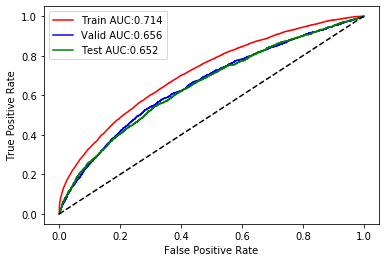

In [93]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Conclusion

Through this project, we created a binary classifier to predict the probability that a patient with diabetes would be readmitted to the hospital within 30 days. On held out test data, our best model had an AUC of of 0.67. Using this model, we are able to catch 58% of the readmissions from our model that performs approximately 1.5 times better than randomly selecting patients. 